# Import Libs

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import argmax

from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import ydata_profiling
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import plot_importance
import dtreeviz.trees



In [2]:
pip install dtreeviz

Note: you may need to restart the kernel to use updated packages.


# Import Data

In [3]:
seed = 104

In [4]:
df = pd.read_csv('data/clean_ismek.csv')

In [5]:
df.shape

(216765, 9)

In [6]:
df.info() # all columns are objects data tpye

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216765 entries, 0 to 216764
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   egitim_durumu          216765 non-null  object
 1   calisma_durumu         216765 non-null  object
 2   alan                   216765 non-null  object
 3   program                216765 non-null  object
 4   hak_edilen_belge_tipi  216765 non-null  object
 5   kurs_merkezi           216765 non-null  object
 6   kurs_merkezi_ilcesi    216765 non-null  object
 7   tercih_sebebi          216765 non-null  object
 8   yas_araligi            216765 non-null  object
dtypes: object(9)
memory usage: 14.9+ MB


In [7]:
df.head()

,egitim_durumu,calisma_durumu,alan,program,hak_edilen_belge_tipi,kurs_merkezi,kurs_merkezi_ilcesi,tercih_sebebi,yas_araligi
0,Lisans,Ogrenci,Dil Egitimleri,Ingilizce A2 Seviyesi,Hak Etmedi,Dil Okulu,Sisli,"Meslek Edinmek, Meslegimde Ýlerlemek",20-30 Yas Arasi
1,Lise,Calismiyor,Spor,Fitness (Kadin),Ismek Sertifika,Silivri Spor Egitim Merkezi,Silivri,"Sanat,Muzik,Spor Vb. Yeteneklerimi Gelistirmek",20-30 Yas Arasi
2,Lisans,Ogrenci,Dil Egitimleri,Ingilizce A1 Seviyesi,Meb Sertifika,Tuzla Yayla Mahallesi,Tuzla,"Meslek Edinmek, Meslegimde Ýlerlemek",30-40 Yas Arasi
3,Lisans,Ogrenci,Spor,Crunch (Kadin),Hak Etmedi,Atasehir Kayisdagi,Atasehir,"Sanat,Muzik,Spor Vb. Yeteneklerimi Gelistirmek",20 Yas Alti
4,Lisans,Ogrenci,Spor,Stretching (Kadin),Hak Etmedi,Atasehir Kayisdagi,Atasehir,"Sanat,Muzik,Spor Vb. Yeteneklerimi Gelistirmek",20 Yas Alti


# HEPFUL FUNCTIONS

In [8]:
def label_encoding(df, target):
    for i in df.columns:
        label_encoder = preprocessing.LabelEncoder()

        # Encode labels in column 'species'.
        df[i]= label_encoder.fit_transform(df[i])
        
        if i == target:
            target_mapping = {l: i for i, l in enumerate(label_encoder.classes_)}
            print(target_mapping) # for target
        
    return df, target_mapping 

In [9]:
def get_X_y(df, target):
    y = df[target].values
    del df[target]
    X = df
    
    return X,y

In [10]:
def get_selected_info(df, column, selected_list):
    new_df = pd.DataFrame()
    for col in selected_list:
        new_df = pd.concat([new_df, df[(df[column] == col)]])
        
    return new_df.reset_index(drop=True)

# ALAN MODELING

In [11]:
top_areas = ['Bilisim Teknolojileri', 'Spor','Grafik Ve Teknik Tasarim', 'Dil Egitimleri', 'Kisisel Gelisim Ve Egitim']

# tahmin yaptircagimiz alanlar bunlar 

- Burada Uzaktan egtim tercih edenler icin %77si 'Bilisim Teknolojileri' alanini sectigi icn f2f ve online olarak iki model olusuturmayi dusunuyorum online olan modelde kurs_merkezi bilgisi olmayacak. 
- 'Bilisim Teknolojileri' ya da 'Grafik Ve Teknik Tasarim','Kisisel Gelisim Ve Egitim' olup olmadigini tahmin etmeye calisacak. diger ozellikleriden.

## Top areas

In [12]:
df_top_areas = df.copy()

In [13]:
# del df_online['kurs_merkezi']
del df_top_areas['program']
# del df_online['kurs_merkezi_ilcesi']

In [14]:
df_top_areas = get_selected_info(df_top_areas,'alan', top_areas)

In [15]:
df_top_areas.shape

(156065, 8)

In [16]:
df_top_areas.alan.value_counts()

Bilisim Teknolojileri        89580
Spor                         23254
Grafik Ve Teknik Tasarim     15405
Dil Egitimleri               14271
Kisisel Gelisim Ve Egitim    13555
Name: alan, dtype: int64

In [17]:
df_top_areas, target_mapping = label_encoding(df_top_areas, 'alan')

{'Bilisim Teknolojileri': 0, 'Dil Egitimleri': 1, 'Grafik Ve Teknik Tasarim': 2, 'Kisisel Gelisim Ve Egitim': 3, 'Spor': 4}


In [18]:
X, y = get_X_y(df_top_areas, target = 'alan')

In [19]:
X_train, X_test,y_train, y_test = train_test_split(X,y ,
                               random_state=seed, 
                               test_size=0.2, 
                               shuffle=True,
                               stratify=y)
    
X_train.shape , y_train.shape, X_test.shape, y_test.shape


((124852, 7), (124852,), (31213, 7), (31213,))

### XGBClassifier

In [20]:
xgb_model = XGBClassifier() 

In [21]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [22]:
xgb_model.score(X_test, y_test) 

0.8235030275846602

In [23]:
y_pred  = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[::,1]

#### Confusion Matrix

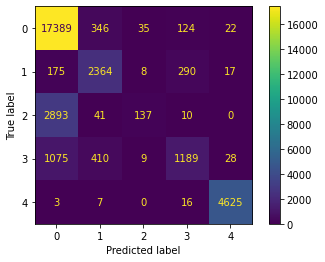

In [24]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

#### Classification Report

In [25]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.97      0.88     17916
           1       0.75      0.83      0.79      2854
           2       0.72      0.04      0.08      3081
           3       0.73      0.44      0.55      2711
           4       0.99      0.99      0.99      4651

    accuracy                           0.82     31213
   macro avg       0.80      0.66      0.66     31213
weighted avg       0.81      0.82      0.78     31213



In [26]:
target_mapping

{'Bilisim Teknolojileri': 0,
 'Dil Egitimleri': 1,
 'Grafik Ve Teknik Tasarim': 2,
 'Kisisel Gelisim Ve Egitim': 3,
 'Spor': 4}

#### Plot importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

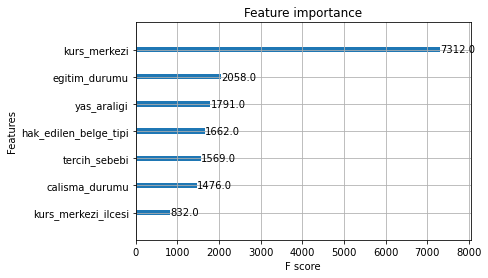

In [27]:
plot_importance(xgb_model)

## Online

In [28]:
df_online = df[df['kurs_merkezi'] == 'Uzaktan Egitim'].copy()
df_online.shape

(105187, 9)

In [29]:
df_online.alan.value_counts()

Bilisim Teknolojileri                   81235
Grafik Ve Teknik Tasarim                14205
Kisisel Gelisim Ve Egitim                4664
Muhasebe Ve Finans                       3848
Moda Tasarimi Ve Tekstil Teknolojisi     1101
Grafik Ve Fotograf                         68
Yabanci Diller                             46
Cocuk Gelisimi Ve Egitimi                  20
Name: alan, dtype: int64

In [30]:
df_online.kurs_merkezi_ilcesi.value_counts()

Esenler    105187
Name: kurs_merkezi_ilcesi, dtype: int64

In [31]:
del df_online['kurs_merkezi']
del df_online['program']
del df_online['kurs_merkezi_ilcesi']

In [32]:
online_areas = ['Bilisim Teknolojileri', 'Grafik Ve Teknik Tasarim', 'Kisisel Gelisim Ve Egitim']

In [33]:
df_online_top3 = get_selected_info(df_online,'alan', online_areas)

In [34]:
df_online_top3.shape

(100104, 6)

In [35]:
df_online_top3.alan.value_counts()

Bilisim Teknolojileri        81235
Grafik Ve Teknik Tasarim     14205
Kisisel Gelisim Ve Egitim     4664
Name: alan, dtype: int64

In [36]:
df_online_top3, target_mapping = label_encoding(df_online_top3, 'alan')

{'Bilisim Teknolojileri': 0, 'Grafik Ve Teknik Tasarim': 1, 'Kisisel Gelisim Ve Egitim': 2}


In [37]:
df_online_top3.head()

,egitim_durumu,calisma_durumu,alan,hak_edilen_belge_tipi,tercih_sebebi,yas_araligi
0,3,3,0,0,0,1
1,3,3,0,1,0,1
2,8,3,0,0,0,1
3,3,0,0,0,1,1
4,3,0,0,0,1,1


In [38]:
X, y = get_X_y(df_online_top3, target = 'alan')

In [39]:
X_train, X_test,y_train, y_test = train_test_split(X,y ,
                               random_state=seed, 
                               test_size=0.2, 
                               shuffle=True,
                               stratify=y)
    
X_train.shape , y_train.shape, X_test.shape, y_test.shape


((80083, 5), (80083,), (20021, 5), (20021,))

### XGBClassifier

In [40]:
xgb_model = XGBClassifier() 

In [41]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [42]:
xgb_model.score(X_test, y_test) 

0.8106488187403227

In [43]:
y_pred  = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[::,1]

#### Confusion Matrix

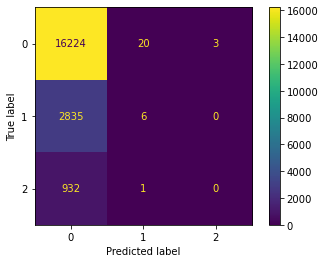

In [44]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

#### Classification Report

In [45]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90     16247
           1       0.22      0.00      0.00      2841
           2       0.00      0.00      0.00       933

    accuracy                           0.81     20021
   macro avg       0.34      0.33      0.30     20021
weighted avg       0.69      0.81      0.73     20021



In [46]:
target_mapping

{'Bilisim Teknolojileri': 0,
 'Grafik Ve Teknik Tasarim': 1,
 'Kisisel Gelisim Ve Egitim': 2}

#### Plot importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

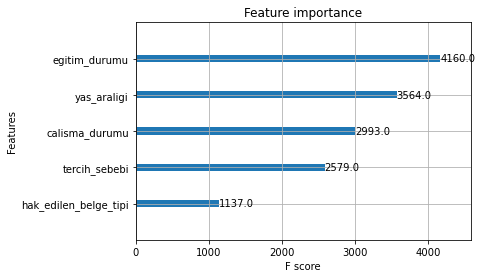

In [47]:
plot_importance(xgb_model)

## F2F

In [48]:
df_f2f = df[df['kurs_merkezi'] != 'Uzaktan Egitim'].copy()
df_f2f.shape

(111578, 9)

In [49]:
df_f2f.alan.value_counts()[:15]

Spor                                    23254
Dil Egitimleri                          14271
Kisisel Gelisim Ve Egitim                8891
Orgu Ve Ýsleme Sanatlari                 8618
Bilisim Teknolojileri                    8345
Moda Tasarimi Ve Tekstil Teknolojisi     6097
Sanat Ve Tasarim                         5652
El Sanatlari Teknolojisi                 5347
Gastronomi Ve Mutfak Sanatlari           5213
Yonetim Ve Hizmet                        3950
Tekstil Tasarimi                         3355
Guzellik Ve Sac Bakim Hizmetleri         2891
Muzik                                    2826
Susleme Sanatlari                        2636
Cocuk Gelisimi Ve Egitimi                1986
Name: alan, dtype: int64

In [50]:
# del df_f2f['kurs_merkezi']
del df_f2f['program']

In [51]:
f2f_areas = ['Bilisim Teknolojileri', 'Dil Egitimleri', 'Kisisel Gelisim Ve Egitim']

In [52]:
df_f2f_top3 = get_selected_info(df_f2f,'alan', f2f_areas)

In [53]:
df_f2f_top3.shape

(31507, 8)

In [54]:
df_f2f_top3.alan.value_counts()

Dil Egitimleri               14271
Kisisel Gelisim Ve Egitim     8891
Bilisim Teknolojileri         8345
Name: alan, dtype: int64

### Spor

In [55]:
spor = get_selected_info(df_f2f,'alan', ['Spor'])

In [56]:
spor.kurs_merkezi.value_counts()[:15]

Kartal Yakacik Spor Egitim Merkezi             1814
Tuzla Spor Egitim Merkezi                      1807
Kartal Atalar Spor Egitim Merkezi              1788
Gungoren Spor Egitim Merkezi                   1600
Kartal Hurriyet Mh. Spor Egitim Merkezi        1591
Umraniye Mithatpasa Spor Egitim Merkezi        1562
Sultanbeyli Mehmet Akif Spor Egitim Merkezi    1520
K.Cekmece Sefakoy Spor Egitim Merkezi          1491
Gaziosmanpasa Spor Egitim Merkezi              1424
Silivri Spor Egitim Merkezi                    1362
Buyukcekmece Mimaroba Spor Egitim Merkezi      1349
Beylikduzu Beykent Spor Egitim Merkezi         1239
Atasehir Kayisdagi                              679
Catalca Spor Egitim Merkezi                     604
Sultangazi Hoca Ahmet Yesevi Kultur Merkezi     354
Name: kurs_merkezi, dtype: int64

In [57]:
spor.kurs_merkezi_ilcesi.value_counts()[:15]

Kartal           5313
Tuzla            2123
Sultanbeyli      1732
Gungoren         1600
Umraniye         1562
Kucukcekmece     1491
Gaziosmanpasa    1424
Silivri          1362
Buyukcekmece     1349
Beylikduzu       1239
Atasehir          978
Pendik            666
Catalca           604
Kagithane         380
Sultangazi        354
Name: kurs_merkezi_ilcesi, dtype: int64

In [58]:
df_f2f_top3, target_mapping = label_encoding(df_f2f_top3, 'alan')

{'Bilisim Teknolojileri': 0, 'Dil Egitimleri': 1, 'Kisisel Gelisim Ve Egitim': 2}


In [59]:
df_f2f_top3.head()

,egitim_durumu,calisma_durumu,alan,hak_edilen_belge_tipi,kurs_merkezi,kurs_merkezi_ilcesi,tercih_sebebi,yas_araligi
0,3,2,0,1,102,26,0,1
1,4,2,0,2,73,23,1,1
2,9,2,0,1,56,17,3,3
3,3,4,0,2,70,23,0,1
4,3,4,0,2,70,23,0,0


In [60]:
X, y = get_X_y(df_f2f_top3, target = 'alan')

In [61]:
X_train, X_test,y_train, y_test = train_test_split(X,y ,
                               random_state=seed, 
                               test_size=0.2, 
                               shuffle=True,
                               stratify=y)
    
X_train.shape , y_train.shape, X_test.shape, y_test.shape


((25205, 7), (25205,), (6302, 7), (6302,))

### XGBClassifier

In [62]:
xgb_model = XGBClassifier() 

In [63]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [64]:
xgb_model.score(X_test, y_test) 

0.7664233576642335

In [65]:
y_pred  = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[::,1]

#### Confusion Matrix

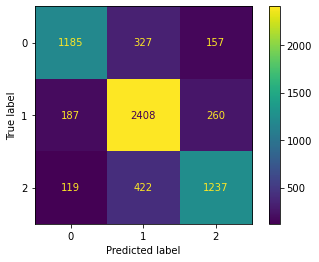

In [66]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

#### Classification Report

In [67]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.71      0.75      1669
           1       0.76      0.84      0.80      2855
           2       0.75      0.70      0.72      1778

    accuracy                           0.77      6302
   macro avg       0.77      0.75      0.76      6302
weighted avg       0.77      0.77      0.76      6302



In [68]:
target_mapping

{'Bilisim Teknolojileri': 0,
 'Dil Egitimleri': 1,
 'Kisisel Gelisim Ve Egitim': 2}

#### Plot importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

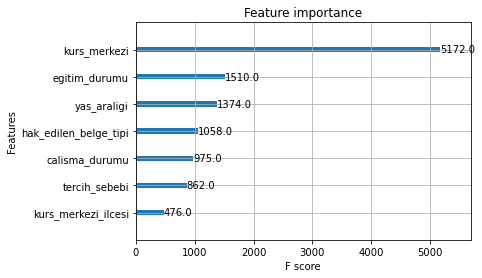

In [69]:
plot_importance(xgb_model)

# PROGRAM MODELING

In [70]:
top_areas = ['Bilisim Teknolojileri', 'Spor','Grafik Ve Teknik Tasarim', 'Dil Egitimleri', 'Kisisel Gelisim Ve Egitim']

# tahmin yaptircagimiz alanlar bunlar 

- Alan bazinda model olusuturup program tahminlemeye calisilacaktir.

## Bilisim Teknolojileri

In [71]:
df_bilisim = get_selected_info(df,'alan', ['Bilisim Teknolojileri'])

In [72]:
del df_bilisim['alan']
# del df_top_areas['program']
# del df_online['kurs_merkezi_ilcesi']

In [73]:
df_bilisim.head()

,egitim_durumu,calisma_durumu,program,hak_edilen_belge_tipi,kurs_merkezi,kurs_merkezi_ilcesi,tercih_sebebi,yas_araligi
0,Lisans,Ogrenci,Powerpoint 2019 Kullanimi,Hak Etmedi,Uzaktan Egitim,Esenler,"Meslek Edinmek, Meslegimde Ýlerlemek",20-30 Yas Arasi
1,Lisans,Ogrenci,Blog Web Sitesi Yapimi Ve Bloggerlik,Ismek Sertifika,Uzaktan Egitim,Esenler,"Meslek Edinmek, Meslegimde Ýlerlemek",20-30 Yas Arasi
2,On Lisans,Ogrenci,Algoritma Ve Programlamaya Temelleri,Hak Etmedi,Uzaktan Egitim,Esenler,"Meslek Edinmek, Meslegimde Ýlerlemek",20-30 Yas Arasi
3,Lisans,Calismiyor,Web Tasarim Gelistirme 1 (Photoshop Ile Web Ar...,Ismek Sertifika,Sancaktepe Samandira,Sancaktepe,"Meslek Edinmek, Meslegimde Ýlerlemek",20-30 Yas Arasi
4,Lisans,Calisiyor,Blog Web Sitesi Yapimi Ve Bloggerlik,Hak Etmedi,Uzaktan Egitim,Esenler,"Sanat,Muzik,Spor Vb. Yeteneklerimi Gelistirmek",20-30 Yas Arasi


In [74]:
df_bilisim.shape

(89580, 8)

In [75]:
df_bilisim.program.value_counts()[:15]

Excel 2019 Kullanimi                                  9570
Algoritma Ve Programlamaya Temelleri                  8241
Blog Web Sitesi Yapimi Ve Bloggerlik                  4512
Uygulamalarla Ileri Excel Formulleri                  4019
Powerpoint 2019 Kullanimi                             3540
Photoshop Ile Web Arayuz Tasarimi (Uzaktan Egitim)    3480
Web Tasarim Icin Photoshop Temelleri                  3173
Bilgisayar Isletmenligi (Operatorlugu)                3158
Wordpress 1 / Web Sitesi Yapimi                       3062
Word 2019 Kullanimi                                   2875
Word Ile Akademik Dokuman (Tez) Hazirlama             2588
Excel Makrolara Giris                                 2554
C# Programlamaya Giris                                2496
Dijital Iletisim Ve Etkilesim Uygulamalari            2353
Egitimde Google Classroom Kullanimi                   2258
Name: program, dtype: int64

In [76]:
df_bilisim, target_mapping = label_encoding(df_bilisim, 'program')

{'Access Ile Temel Veri Tabani Tasarimi': 0, 'Adobe Xd Ile Mobil Uygulama Tasarimi': 1, 'Algoritma Ve Programlama Temelleri': 2, 'Algoritma Ve Programlamaya Temelleri': 3, 'Android Programlama 1 (Mobil Uygulama Gelistirme)': 4, 'Android Programlama 2 (Ileri Uygulama Gelistirme)': 5, 'Android Programlamaya Giris': 6, 'App Inventor Ile Android Uygulama Gelistirme': 7, 'Asp.Net Programlama 2 (Mvc Uygulamalari Gelistirme)': 8, 'Asp.Net Programlama 3 (.Net Core Ve Mvc Ile Kurumsal Mimari)': 9, 'Bilgi Guvenligi Bilinclendirme Egitimi': 10, 'Bilgisayar Isletmenligi (Operatorlugu)': 11, 'Bilgisayar Programlama Teknikleri': 12, 'Bilgisayar Sistem Bakim Onarim': 13, 'Bilgisayarda Dokuman Hazirlama': 14, 'Blog Web Sitesi Yapimi (12-16 Yas Egitimi)': 15, 'Blog Web Sitesi Yapimi Ve Bloggerlik': 16, 'C# Programlamaya Giris': 17, 'Camtasia 2019 Kullanimi': 18, 'Cevrim Ici Anket Uygulamasi : Google Formlar Kullanimi': 19, 'Cevrim Ici Depolama Alani Uygulamasi : Google Drive Kullanimi': 20, 'Cevrim Ici

In [77]:
df_bilisim.head(3)

,egitim_durumu,calisma_durumu,program,hak_edilen_belge_tipi,kurs_merkezi,kurs_merkezi_ilcesi,tercih_sebebi,yas_araligi
0,3,4,65,0,86,12,0,1
1,3,4,16,1,86,12,0,1
2,8,4,3,0,86,12,0,1


In [78]:
X, y = get_X_y(df_bilisim, target = 'program')

In [79]:
X_train, X_test,y_train, y_test = train_test_split(X,y ,
                               random_state=seed, 
                               test_size=0.2, 
                               shuffle=True,
                               stratify=y)
    
X_train.shape , y_train.shape, X_test.shape, y_test.shape


((71664, 7), (71664,), (17916, 7), (17916,))

### DecisionTreeClassifier

In [80]:
dtc_model = DecisionTreeClassifier()

In [81]:
dtc_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [82]:
dtc_model.score(X_test, y_test) 

0.15924313462826523

In [83]:
y_pred  = dtc_model.predict(X_test)
y_pred_proba = dtc_model.predict_proba(X_test)[::,1]

#### Confusion Matrix

In [84]:
# ConfusionMatrixDisplay.from_predictions(y_test, y_pred) # There are too many programs.
plt.show()

#### Classification Report

In [85]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.00      0.00      0.00       146
           2       0.08      0.04      0.05        24
           3       0.13      0.19      0.16      1648
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00       108
           7       0.33      0.20      0.25         5
           8       0.09      0.08      0.08        13
           9       0.00      0.00      0.00         6
          10       0.00      0.00      0.00         3
          11       0.73      0.77      0.75       632
          12       0.23      0.30      0.26        10
          13       0.08      0.08      0.08        12
          14       0.24      0.22      0.23        46
          15       0.00      0.00      0.00         3
          16       0.14      0.18      0.16       902
          17       0.07    

C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


#### Plot importance

<AxesSubplot:>

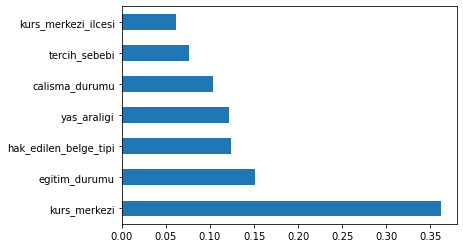

In [87]:
feat_importances = pd.Series(dtc_model.feature_importances_, index=df_bilisim.columns)
feat_importances.sort_values(ascending= False).plot(kind='barh')

## Spor

In [88]:
df_spor = get_selected_info(df,'alan', ['Spor'])

In [89]:
del df_spor['alan']
# del df_top_areas['program']
# del df_online['kurs_merkezi_ilcesi']

In [90]:
df_spor.shape

(23254, 8)

In [91]:
df_spor.program.value_counts()[:15]

Fitness (Kadin)       6622
Fitness (Erkek)       5267
Pilates 1. Seviye     5078
Aerobik               4001
Crunch (Kadin)        1598
Stretching (Kadin)     688
Name: program, dtype: int64

In [92]:
df_spor, target_mapping = label_encoding(df_spor, 'program')

{'Aerobik': 0, 'Crunch (Kadin)': 1, 'Fitness (Erkek)': 2, 'Fitness (Kadin)': 3, 'Pilates 1. Seviye': 4, 'Stretching (Kadin)': 5}


In [93]:
df_spor.head(3)

,egitim_durumu,calisma_durumu,program,hak_edilen_belge_tipi,kurs_merkezi,kurs_merkezi_ilcesi,tercih_sebebi,yas_araligi
0,4,2,3,1,19,13,1,1
1,3,4,1,0,1,0,1,0
2,3,4,5,0,1,0,1,0


In [94]:
X, y = get_X_y(df_spor, target = 'program')

In [95]:
X_train, X_test,y_train, y_test = train_test_split(X,y ,
                               random_state=seed, 
                               test_size=0.2, 
                               shuffle=True,
                               stratify=y)
    
X_train.shape , y_train.shape, X_test.shape, y_test.shape


((18603, 7), (18603,), (4651, 7), (4651,))

### XGBClassifier

In [96]:
model = XGBClassifier() 

In [97]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [98]:
model.score(X_test, y_test) 

0.4889271124489357

In [99]:
y_pred  = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[::,1]

#### Confusion Matrix

In [100]:
# ConfusionMatrixDisplay.from_predictions(y_test, y_pred) # There are too many programs.
plt.show()

#### Classification Report

In [101]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.43      0.21      0.28       800
           1       0.20      0.06      0.10       320
           2       0.62      0.79      0.69      1053
           3       0.46      0.74      0.57      1324
           4       0.42      0.25      0.32      1016
           5       0.22      0.09      0.13       138

    accuracy                           0.49      4651
   macro avg       0.39      0.36      0.35      4651
weighted avg       0.46      0.49      0.45      4651



In [102]:
target_mapping

{'Aerobik': 0,
 'Crunch (Kadin)': 1,
 'Fitness (Erkek)': 2,
 'Fitness (Kadin)': 3,
 'Pilates 1. Seviye': 4,
 'Stretching (Kadin)': 5}

#### Plot importance

<AxesSubplot:>

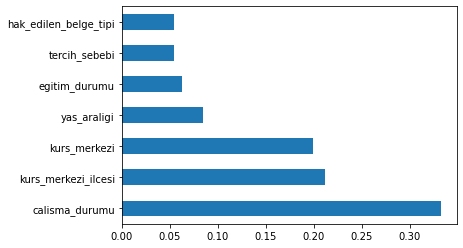

In [103]:
feat_importances = pd.Series(model.feature_importances_, index=df_spor.columns)
feat_importances.sort_values(ascending= False).plot(kind='barh')

- Genel olarak bu sekilde bir program tahminlemesi yapilmada mumkun gorunmuyor
- Belki ihtimal dahlinde tavsiye verilebilir.